<a href="https://colab.research.google.com/github/taeyang916/Low-Rank-Adaptation-Practice/blob/main/Object_Detection/detr_LoRA_coco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install accelerate peft ipywidgets datasets evaluate albumentations timm transformers[torch] torchmetrics

In [33]:
import transformers
import accelerate
import peft
print(f"Transformers version: {transformers.__version__}")
print(f"Accelerate version: {accelerate.__version__}")
print(f"PEFT version: {peft.__version__}")

Transformers version: 4.41.2
Accelerate version: 0.31.0
PEFT version: 0.11.1


In [34]:
from huggingface_hub import notebook_login

notebook_login()

In [35]:
model_checkpoint = "facebook/detr-resnet-50-dc5"

In [36]:
from datasets import load_dataset

dataset = load_dataset("detection-datasets/coco")

Resolving data files:   0%|          | 0/40 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/20 [00:00<?, ?it/s]

In [37]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 117266
    })
    val: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 4952
    })
})

In [38]:
ds = dataset['train']

In [39]:
train_dataset = dataset["train"]
val_dataset = dataset["val"]

In [40]:
ds[2]

{'image_id': 30,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x428>,
 'width': 640,
 'height': 428,
 'objects': {'bbox_id': [291613, 1155486],
  'category': [58, 75],
  'bbox': [[204.86, 31.02, 459.74, 355.14],
   [237.56, 155.81, 403.96000000000004, 351.06]],
  'area': [47675.66289999999, 16202.798250000003]}}

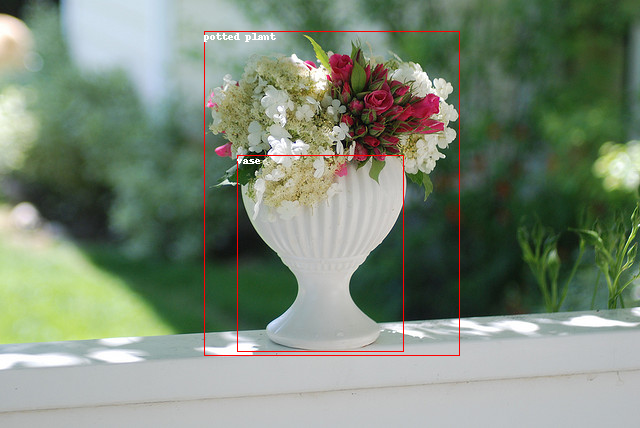

In [41]:
import numpy as np
import os
from PIL import Image, ImageDraw
width = 480
height = 480
image = dataset["train"][2]["image"]
annotations = dataset["train"][2]["objects"]
draw = ImageDraw.Draw(image)

categories = dataset["train"].features["objects"].feature["category"].names

id2label = {index: x for index, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

for i in range(len(annotations["bbox_id"])):
    box = annotations["bbox"][i]
    class_idx = annotations["category"][i]
    x, y, w, h = tuple(box)
    # Check if coordinates are normalized or not
    # if max(box) > 1.0:
    #     # Coordinates are un-normalized, no need to re-scale them
    #     x1, y1 = int(x), int(y)
    #     x2, y2 = int(x + w), int(y + h)
    # else:
    #     # Coordinates are normalized, re-scale them
    #     x1 = int(x * width)
    #     y1 = int(y * height)
    #     x2 = int((x + w) * width)
    #     y2 = int((y + h) * height)
    draw.rectangle((x, y, w, h), outline="red", width=1)
    draw.text((x, y), id2label[class_idx], fill="white")

image

In [42]:
ds.features['objects'].feature['category']

ClassLabel(names=['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'], id=None)

In [43]:
labels = ds.features['objects'].feature['category'].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label]=i
    id2label[i]=label

print(f"id2label[3] : {id2label[3]}")

id2label[3] : motorcycle


In [44]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)

In [45]:
import albumentations
import numpy as np
import torch

transform = albumentations.Compose(
    [
        albumentations.Resize(224, 224),
        albumentations.HorizontalFlip(p=0.1),
        albumentations.RandomBrightnessContrast(p=0.1),
    ],
    # I use coco dataset. But, in this dataset, already preprocessed (x_min, y_min, x_max, y_max) format. So, I use pascal_voc format
    bbox_params=albumentations.BboxParams(format="pascal_voc", label_fields=["category"]),
    # bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

In [46]:
import albumentations as A

train_augment_and_transform = A.Compose(
    [
        A.Perspective(p=0.1),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.1),
    ],
    bbox_params=A.BboxParams(format="pascal_voc", label_fields=["category"]),
)

validation_transform = A.Compose(
    [A.NoOp()],
    bbox_params=A.BboxParams(format="pascal_voc", label_fields=["category"]),
)

In [47]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

In [48]:
def transform_aug_ann(image_id, categories, areas, bboxes):
    annotations = []
    for category, area, bbox in zip(categories, areas, bboxes):
        formatted_annotation = {
            "image_id": image_id,
            "category_id": category,
            "iscrowd": 0,
            "area": area,
            "bbox": list(bbox),
        }
        annotations.append(formatted_annotation)

    return {
        "image_id": image_id,
        "annotations": annotations
    }

In [49]:
def augment_and_transform_batch(examples, transform, image_processor, return_pixel_mask=False):
    """Apply augmentations and format annotations in COCO format for object detection task"""

    images = []
    annotations = []
    for image_id, image, objects in zip(examples["image_id"], examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))

        # apply augmentations
        output = transform(image=image, bboxes=objects["bbox"], category=objects["category"])
        images.append(output["image"])

        # format annotations in COCO format
        formatted_annotations = transform_aug_ann(
            image_id, output["category"], objects["area"], output["bboxes"]
        )
        annotations.append(formatted_annotations)

    # Apply the image processor transformations: resizing, rescaling, normalization
    result = image_processor(images=images, annotations=annotations, return_tensors="pt")

    if not return_pixel_mask:
        result.pop("pixel_mask", None)

    return result

In [50]:
from functools import partial

# Make transform functions for batch and apply for dataset splits
train_transform_batch = partial(
    augment_and_transform_batch, transform=train_augment_and_transform, image_processor=image_processor
)
validation_transform_batch = partial(
    augment_and_transform_batch, transform=validation_transform, image_processor=image_processor
)

In [51]:
train_dataset_transformed = train_dataset.with_transform(train_transform_batch)
val_dataset_transformed = val_dataset.with_transform(validation_transform_batch)

In [ ]:
train_dataset_transformed[2]

In [53]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

In [54]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

In [55]:
from transformers import AutoModelForObjectDetection
import timm

model = AutoModelForObjectDetection.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of the model checkpoint at facebook/detr-resnet-50-dc5 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model check

In [56]:
print_trainable_parameters(model)

trainable params: 41299541 || all params: 41521941 || trainable%: 99.46


In [57]:
# # check difference with ViT and DETR
# vit_checkpoint = "google/vit-base-patch16-224-in21k"
# vit_processor = AutoImageProcessor.from_pretrained(vit_checkpoint)
# from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

# vit_model = AutoModelForImageClassification.from_pretrained(
#     vit_checkpoint,
#     label2id=label2id,
#     id2label=id2label,
#     ignore_mismatched_sizes=True,
# )
# vit_model

In [58]:
# model

In [66]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=['q_proj','v_proj'],
    lora_dropout=0.1,
    bias='none',
    modules_to_save=['object_detection'],
)
lora_model = get_peft_model(model, config)
print_trainable_parameters(lora_model)

trainable params: 147456 || all params: 41669397 || trainable%: 0.35


In [67]:
model_name = model_checkpoint.split('/')[-1]
batch_size = 4
model_name

'detr-resnet-50-dc5'

In [68]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

training_args = TrainingArguments(
    f"{model_name}-finetuned-lora-coco",
    remove_unused_columns=False,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=1e-5,
    weight_decay=1e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    max_steps=1000,
    max_grad_norm=0.01,
    fp16=True,
    num_train_epochs=5,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    save_total_limit=2,
    push_to_hub=True,
    label_names=['labels'],
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [70]:
import numpy as np
from dataclasses import dataclass
from torchmetrics.detection.mean_ap import MeanAveragePrecision


@dataclass
class ModelOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor


@torch.no_grad()
def compute_metrics(evaluation_results, image_processor, threshold=0.0, id2label=None):
    """
    Compute mean average mAP, mAR and their variants for the object detection task.

    Args:
        evaluation_results (EvalPrediction): Predictions and targets from evaluation.
        threshold (float, optional): Threshold to filter predicted boxes by confidence. Defaults to 0.0.
        id2label (Optional[dict], optional): Mapping from class id to class name. Defaults to None.

    Returns:
        Mapping[str, float]: Metrics in a form of dictionary {<metric_name>: <metric_value>}
    """

    predictions, targets = evaluation_results.predictions, evaluation_results.label_ids

    # For metric computation we need to provide:
    #  - targets in a form of list of dictionaries with keys "boxes", "labels"
    #  - predictions in a form of list of dictionaries with keys "boxes", "scores", "labels"

    image_sizes = []
    post_processed_targets = []
    post_processed_predictions = []

    # Collect targets in the required format for metric computation
    for batch in targets:
        # collect image sizes, we will need them for predictions post processing
        batch_image_sizes = torch.tensor(np.array([x["orig_size"] for x in batch]))
        image_sizes.append(batch_image_sizes)
        # collect targets in the required format for metric computation
        # boxes were converted to YOLO format needed for model training
        # here we will convert them to Pascal VOC format (x_min, y_min, x_max, y_max)
        for image_target in batch:
            boxes = torch.tensor(image_target["boxes"])
            boxes = convert_bbox_yolo_to_pascal(boxes, image_target["orig_size"])
            labels = torch.tensor(image_target["class_labels"])
            post_processed_targets.append({"boxes": boxes, "labels": labels})

    # Collect predictions in the required format for metric computation,
    # model produce boxes in YOLO format, then image_processor convert them to Pascal VOC format
    for batch, target_sizes in zip(predictions, image_sizes):
        batch_logits, batch_boxes = batch[1], batch[2]
        output = ModelOutput(logits=torch.tensor(batch_logits), pred_boxes=torch.tensor(batch_boxes))
        post_processed_output = image_processor.post_process_object_detection(
            output, threshold=threshold, target_sizes=target_sizes
        )
        post_processed_predictions.extend(post_processed_output)

    # Compute metrics
    metric = MeanAveragePrecision(box_format="xyxy", class_metrics=True)
    metric.update(post_processed_predictions, post_processed_targets)
    metrics = metric.compute()

    # Replace list of per class metrics with separate metric for each class
    classes = metrics.pop("classes")
    map_per_class = metrics.pop("map_per_class")
    mar_100_per_class = metrics.pop("mar_100_per_class")
    for class_id, class_map, class_mar in zip(classes, map_per_class, mar_100_per_class):
        class_name = id2label[class_id.item()] if id2label is not None else class_id.item()
        metrics[f"map_{class_name}"] = class_map
        metrics[f"mar_100_{class_name}"] = class_mar

    metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

    return metrics


eval_compute_metrics_fn = partial(
    compute_metrics, image_processor=image_processor, id2label=id2label, threshold=0.0
)

In [71]:
torch.cuda.empty_cache()

In [72]:
trainer = Trainer(
    lora_model,
    training_args,
    train_dataset=train_dataset_transformed,
    eval_dataset=val_dataset_transformed,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)
train_results = trainer.train()

max_steps is given, it will override any value given in num_train_epochs


OutOfMemoryError: CUDA out of memory. Tried to allocate 882.00 MiB. GPU 